# MMCi Block 1 Computational Exercise
---
*From Logistic Regression to the Multilayer Perceptron: Predicting Clinic Appointment No-Shows*

In this exercise, we will work with a dataset of [over 100k clinic appointments](https://www.kaggle.com/joniarroba/noshowappointments) to predict no-shows based on patient characteristics and appointment scheduling details. After importing and preprocessing the data, we will train logistic regression and multilayer perceptron models and compare their performance. After selecting a final model, we will apply it to a test set that we initially set aside.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

### Data Import
We will begin by loading the data from .csv file with the 'pandas' data analysis library. Data is read with the `pd.read_csv()` command, which creates a pandas dataframe from the specified .csv file. In this command, we also tell pandas that some columns should be interpreted as a datetime, and others should be interpreted as categorical variables. After reading the file, we will drop unneeded columns using the `df.drop()` command, drop rows with missing values using the `df.dropna()` command, and rename misspelled column headers using `df.rename()`. Finally, we can preview the resulting dataframe using `df.head()`.

In [2]:
datafile = '../data/noshows_raw.csv'

datatypes = {'Gender': 'category',
             'Age': np.float32,
             'Neighbourhood': 'category',
             'Handcap': 'category'}

datetime_columns = ['ScheduledDay', 'AppointmentDay']

columns_to_exclude = ['PatientId', 'AppointmentID']

df = pd.read_csv(
    datafile,
    dtype=datatypes,
    parse_dates=datetime_columns)

df = df.drop(columns_to_exclude, axis=1).dropna()

df = df.rename(columns={'Neighbourhood': 'Neighborhood',
                        'Hipertension': 'Hypertension',
                        'Handcap': 'Handicap',
                        'Gender': 'Sex'})

print('Successfully loaded', len(df), 'records.')
df.head(10)

Successfully loaded 110527 records.


,Sex,ScheduledDay,AppointmentDay,Age,Neighborhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMS_received,No-show
0,F,2016-04-29 18:38:08,2016-04-29,62.0,JARDIM DA PENHA,0,1,0,0,0,0,No
1,M,2016-04-29 16:08:27,2016-04-29,56.0,JARDIM DA PENHA,0,0,0,0,0,0,No
2,F,2016-04-29 16:19:04,2016-04-29,62.0,MATA DA PRAIA,0,0,0,0,0,0,No
3,F,2016-04-29 17:29:31,2016-04-29,8.0,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,F,2016-04-29 16:07:23,2016-04-29,56.0,JARDIM DA PENHA,0,1,1,0,0,0,No
5,F,2016-04-27 08:36:51,2016-04-29,76.0,REPÚBLICA,0,1,0,0,0,0,No
6,F,2016-04-27 15:05:12,2016-04-29,23.0,GOIABEIRAS,0,0,0,0,0,0,Yes
7,F,2016-04-27 15:39:58,2016-04-29,39.0,GOIABEIRAS,0,0,0,0,0,0,Yes
8,F,2016-04-29 08:02:16,2016-04-29,21.0,ANDORINHAS,0,0,0,0,0,0,No
9,F,2016-04-27 12:48:25,2016-04-29,19.0,CONQUISTA,0,0,0,0,0,0,No


For this exercise, we will simplify the problem by correcting the imbalance between 'Shows' and 'No-Shows' in the dataset. Without doing this, an accuracy of $\frac{Show}{Total} \approx 79.8\%$ can be achieved with a classifier that always predicts 'Show', which turns out to be a difficult benchmark to beat.

In [3]:
show = df['No-show'] == 'No'
noshow = df['No-show'] == 'Yes'

print('There are', sum(show), 'Shows and', sum(noshow), 'No-Shows in the dataset.')

df = pd.concat([df[noshow], df[show].sample(n=sum(noshow), random_state=0)])

print('After correcting this imbalance, we have', len(df), 'records.')

There are 88208 Shows and 22319 No-Shows in the dataset.
After correcting this imbalance, we have 44638 records.


### Descriptive Statistics
Let's quickly take a look at some descriptive statistics for the dataset as a whole, starting with age and sex. We can use the `series.describe()` command for numeric variables, and the `series.value_counts()` command for categorical variables. Note that the use of square brackets around a column name (e.g. `df['Age']`) allows us to pick out that column of the dataframe.

In [4]:
df['Age'].describe()

count    44638.000000
mean        36.076080
std         22.744379
min         -1.000000
25%         17.000000
50%         35.000000
75%         54.000000
max        115.000000
Name: Age, dtype: float64

In [5]:
df['Sex'].value_counts()

F    29094
M    15544
Name: Sex, dtype: int64

Since several of the columns are (0, 1)-valued, we can describe them together more compactly.

In [6]:
col = ['Scholarship', 'Hypertension', 'Diabetes', 'Alcoholism', 'SMS_received']
df[col].apply(pd.Series.value_counts).T

,0,1
Scholarship,39926,4712
Hypertension,36287,8351
Diabetes,41535,3103
Alcoholism,43293,1345
SMS_received,28329,16309


Instead of listing all the neighborhoods, let's first see how many there are, then create a histogram to see how many neighborhoods are common.

There are 80 different neighborhoods.


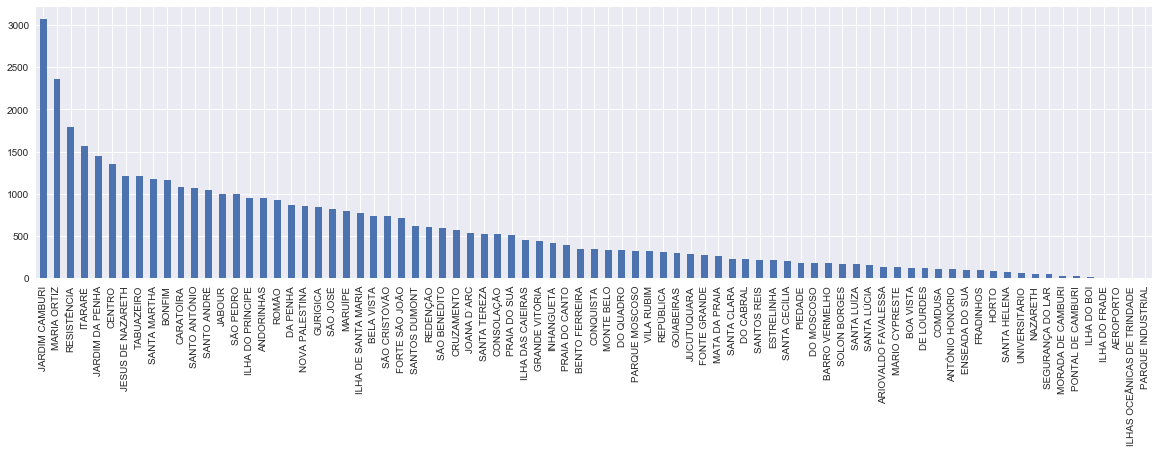

In [7]:
print('There are', len(df['Neighborhood'].unique()), 'different neighborhoods.')
plt.figure(figsize=(20,5))
df['Neighborhood'].value_counts().plot(kind='bar', rot=90)
plt.show()

### Data Preprocessing
First, to avoid unnecessarily expanding our feature set, we will label neighborhoods with fewer than 200 examples as 'Other'. Strictly speaking, this determination should be made using the training set alone. For the purposes of illustration, we will modify the entire dataset together to avoid complicating our code. Don't worry about the details of this code block -- the point is that we are simplifying our 'Neighborhood' variable.

There are 56 different neighborhoods.


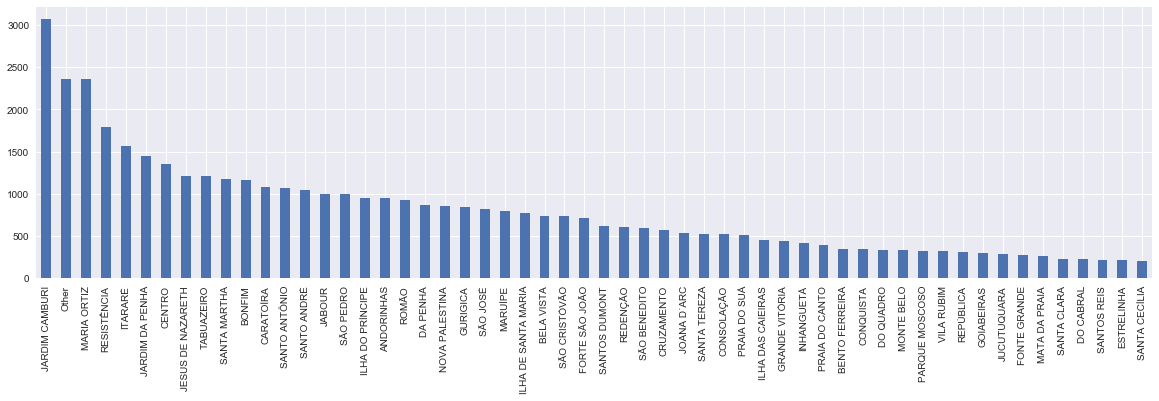

In [8]:
uncommon_neighborhoods = df['Neighborhood'].value_counts()[df['Neighborhood'].value_counts() < 200].index.values
neighborhood_assign = {x:('Other' if x in uncommon_neighborhoods else x) for x in df['Neighborhood'].unique()}

df['Neighborhood'] = df['Neighborhood'].map(
    neighborhood_assign).astype('category',categories=set(neighborhood_assign.values()))
print('There are', len(df['Neighborhood'].unique()), 'different neighborhoods.')
plt.figure(figsize=(20,5))
df['Neighborhood'].value_counts().plot(kind='bar', rot=90)
plt.show()

For our model, we will need to 'one-hot encode' our categorical features. We also need to look at the time difference between appointment scheduling and the appointment itself. We will create two simple helper functions to do this.

In [9]:
def replace_categories_with_one_hot(df, col):
    return pd.concat([df.drop(col, axis=1), pd.get_dummies(df[col], prefix=col)], axis=1)

def difference_in_days(df, col1, col2):
    return (df[col2].dt.date - df[col1].dt.date).dt.days

With these helpers defined, we will add several new features. These are described in comments (e.g. `# comment`) in the code block below.

In [10]:
# How many days have elapsed between scheduling the appointment and the appointment itself?
df['WaitLength'] = difference_in_days(df, 'ScheduledDay', 'AppointmentDay')

# Was this a same-day appointment?
df['SameDay'] = (df['WaitLength'] == 0).astype(np.int64)

# In which hour of the day was it scheduled?
df['ScheduledHour'] = df['ScheduledDay'].dt.hour

# On which day of the week was it scheduled? Which day was the appointment?
df['ScheduledDayOfWeek'] = df['ScheduledDay'].dt.dayofweek
df['AppointmentDayOfWeek'] = df['AppointmentDay'].dt.dayofweek

# Now, remove datetime columns
df = df.drop(['ScheduledDay', 'AppointmentDay'], axis=1)

# Convert categorical variables with > 2 categories to one-hot encoding
df = replace_categories_with_one_hot(df, 'Handicap')
df = replace_categories_with_one_hot(df, 'Neighborhood')
df = replace_categories_with_one_hot(df, 'ScheduledHour')
df = replace_categories_with_one_hot(df, 'ScheduledDayOfWeek')
df = replace_categories_with_one_hot(df, 'AppointmentDayOfWeek')

# Convert categorical variables with 2 categories to binary encoding
df['Sex'] = (df['Sex'] == 'F').astype(np.int64)
df['No-show'] = (df['No-show'] == 'Yes').astype(np.int64)

# View resulting dataframe
df.head(10)

,Sex,Age,Scholarship,Hypertension,Diabetes,Alcoholism,SMS_received,No-show,WaitLength,SameDay,...,ScheduledDayOfWeek_2,ScheduledDayOfWeek_3,ScheduledDayOfWeek_4,ScheduledDayOfWeek_5,AppointmentDayOfWeek_0,AppointmentDayOfWeek_1,AppointmentDayOfWeek_2,AppointmentDayOfWeek_3,AppointmentDayOfWeek_4,AppointmentDayOfWeek_5
6,1,23.0,0,0,0,0,0,1,2,0,...,1,0,0,0,0,0,0,0,1,0
7,1,39.0,0,0,0,0,0,1,2,0,...,1,0,0,0,0,0,0,0,1,0
11,0,29.0,0,0,0,0,1,1,3,0,...,0,0,0,0,0,0,0,0,1,0
17,1,40.0,1,0,0,0,0,1,1,0,...,0,1,0,0,0,0,0,0,1,0
20,1,30.0,0,0,0,0,0,1,2,0,...,1,0,0,0,0,0,0,0,1,0
21,1,4.0,0,0,0,0,0,1,2,0,...,1,0,0,0,0,0,0,0,1,0
22,0,13.0,0,0,0,0,1,1,4,0,...,0,0,0,0,0,0,0,0,1,0
31,0,12.0,1,0,0,0,0,1,2,0,...,1,0,0,0,0,0,0,0,1,0
44,1,78.0,0,1,1,0,0,1,1,0,...,0,1,0,0,0,0,0,0,1,0
48,1,58.0,0,0,0,0,1,1,3,0,...,0,0,0,0,0,0,0,0,1,0


Finally, we will normalize our only two numeric variables: Age and WaitLength

In [11]:
df['Age'] = (df['Age'] - df['Age'].mean()) / df['Age'].std()
df['WaitLength'] = (df['WaitLength'] - df['WaitLength'].mean()) / df['WaitLength'].std()

### Partitioning our data into train, validation, and test sets
We will first randomize the order of our data using the `df.sample()` command. Having randomized, we will use 70% of the data for training and 15% for validation. The final 15% will be set aside as a test set to be used only at the very end of our model development process. In this phase, we also separate our labels (y), which are found in the 'No-show' column, from our features (x) in the other columns.

In [13]:
shuffled_df = df.sample(frac=1, random_state=0).reset_index(drop=True)

val_start_idx = int(.7 * len(df))
test_start_idx = int(.85 * len(df))

x_train = shuffled_df[:val_start_idx].drop('No-show', axis=1)
x_val = shuffled_df[val_start_idx:test_start_idx].drop('No-show', axis=1)
x_test = shuffled_df[test_start_idx:].drop('No-show', axis=1)

y_train = shuffled_df[:val_start_idx]['No-show']
y_val = shuffled_df[val_start_idx:test_start_idx]['No-show']
y_test = shuffled_df[test_start_idx:]['No-show']

print('Our train, validation, and test sets contain %i, %i, and %i instances, respectively.' % (
    len(x_train), len(x_val), len(x_test)))

Our train, validation, and test sets contain 31246, 6696, and 6696 instances, respectively


### Fitting a vanilla logistic regression model

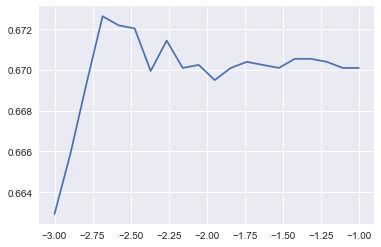

In [18]:
accuracy = []

C_range = np.logspace(-3, -1, 20)

for C in C_range:
    lrm = LogisticRegression(C=C).fit(x_train, y_train)
    predictions = lrm.predict(x_val)
    accuracy.append(sum(y_val == predictions) / len(predictions))
    
plt.plot(np.log10(C_range), accuracy)

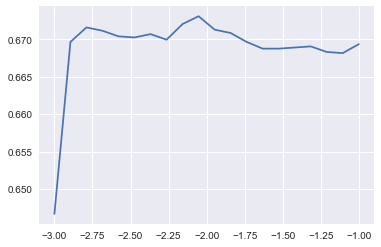

In [19]:
accuracy = []

C_range = np.logspace(-3, -1, 20)

for C in C_range:
    lrm = LogisticRegression(C=C, penalty='l1').fit(x_train, y_train)
    predictions = lrm.predict(x_val)
    accuracy.append(sum(y_val == predictions) / len(predictions))
    
plt.plot(np.log10(C_range), accuracy)

Run Complete
Run Complete
Run Complete
Run Complete


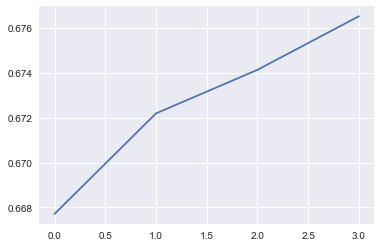

In [25]:
accuracy = []

layers = [(10), (100), (1000), (10000)]

for layer in layers:
    lrm = MLPClassifier(hidden_layer_sizes=layer, early_stopping=True)
    lrm.fit(x_train, y_train)
    predictions = lrm.predict(x_val)
    accuracy.append(sum(y_val == predictions) / len(predictions))
    print('Run Complete')
    
plt.plot(np.arange(len(layers)), accuracy)

Run Complete
Run Complete
Run Complete
Run Complete


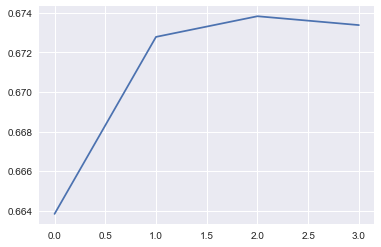

In [26]:
accuracy = []

layers = [(), (100), (100, 100), (100, 100, 100)]

for layer in layers:
    lrm = MLPClassifier(hidden_layer_sizes=layer, early_stopping=True)
    lrm.fit(x_train, y_train)
    predictions = lrm.predict(x_val)
    accuracy.append(sum(y_val == predictions) / len(predictions))
    print('Run Complete')

plt.plot(np.arange(len(layers)), accuracy)